In [4]:

# Required: pip install langchain langchain-ollama, langchain-chroma, langchain-core langchain-community

from langchain_core.tools import tool
from langchain.agents import create_agent
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_chroma import Chroma
from dotenv import load_dotenv

load_dotenv()

# ============================================================================
# LLM & VECTOR STORE SETUP
# ============================================================================
# Ollama LLM with llama3
llm = ChatOllama(
    model="llama3.2:3b", 
    base_url="http://localhost:11434"
)

# Ollama Embeddings
embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
    base_url="http://localhost:11434"
)

# Chroma Vector Store (assumes data already exists from previous code)
vector_store = Chroma(
    collection_name="pdf_collection",
    embedding_function=embeddings,
    persist_directory="../01-semantic-search/chroma_db"
)

print("✓ Using Ollama llama3 + nomic-embed-text")
print("✓ Connected to existing Chroma vector store")

✓ Using Ollama llama3 + nomic-embed-text
✓ Connected to existing Chroma vector store


In [5]:
llm.invoke("Hello")

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2025-11-24T13:46:20.50097Z', 'done': True, 'done_reason': 'stop', 'total_duration': 9125236934, 'load_duration': 6935346666, 'prompt_eval_count': 26, 'prompt_eval_duration': 1663968308, 'eval_count': 8, 'eval_duration': 433829276, 'logprobs': None, 'model_name': 'llama3.2:3b', 'model_provider': 'ollama'}, id='lc_run--cdbde568-d346-46c2-9ed6-222382f9505e-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})

In [6]:
# ============================================================================
# VECTOR STORE VERIFICATION

# ============================================================================
print("\n🔍 Testing Vector Store Connection...")

# Test 1: Check collection info
collection = vector_store._collection
doc_count = collection.count()
print(f"✓ Collection '{collection.name}' found with {doc_count} documents")


# Test 2: Sample similarity search
test_query = "Docker Setup"
results = vector_store.similarity_search(test_query, k=3)
print(f"\n✓ Sample search for '{test_query}':")
for i, doc in enumerate(results, 1):
    print(f"  {i}. Page {doc.metadata.get('page', '?')}: {doc.page_content[:100]}...")


🔍 Testing Vector Store Connection...
✓ Collection 'pdf_collection' found with 270 documents

✓ Sample search for 'Docker Setup':
  1. Page 0: image management, Docker relies heavily on this storage backend, which communicates
with the underly...
  2. Page 0: image management, Docker relies heavily on this storage backend, which communicates
with the underly...
  3. Page 13: and upload any containers that you build.
To create your account, use a web browser of your choice t...


In [7]:
# ============================================================================
# RETRIEVAL TOOL
# ============================================================================
@tool(response_format="content_and_artifact")
def retrieve_context(query: str):
    """Retrieve relevant information from the document to answer the query."""
    print(f"🔍 Searching: '{query}'")
    
    # Perform similarity search
    docs = vector_store.similarity_search(query, k=4)
    
    # Format for LLM
    content = "\n\n".join(
        f"Page {doc.metadata.get('page', '?')}: {doc.page_content}" 
        for doc in docs
    )
    
    print(f"✓ Found {len(docs)} relevant chunks")
    return content, docs

# ============================================================================
# AGENT CREATION
# ============================================================================
# Tools for the agent (single tool only)
tools = [retrieve_context]

# Agent prompt - simplified for single tool
prompt = """You are a research assistant with a document retrieval tool.

Tool:
- retrieve_context: Search the document for relevant information

Always use the tool to find relevant information before answering.
Cite page numbers and be thorough."""

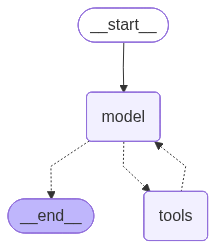

In [8]:
# Create the agentic RAG
rag_agent = create_agent(llm, tools, system_prompt=prompt) 

rag_agent

In [9]:
response = rag_agent.invoke({
      'messages': [
          {"role": "user", "content": "What are the main methods mentioned in this paper?"}
      ]
})

🔍 Searching: 'main methods mentioned in the paper'
✓ Found 4 relevant chunks


In [10]:
response

{'messages': [HumanMessage(content='What are the main methods mentioned in this paper?', additional_kwargs={}, response_metadata={}, id='4545e7c5-d7f3-4ab4-b88a-b097627e9e9c'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2025-11-24T13:46:36.787275Z', 'done': True, 'done_reason': 'stop', 'total_duration': 14546305561, 'load_duration': 5693414097, 'prompt_eval_count': 205, 'prompt_eval_duration': 7617962988, 'eval_count': 18, 'eval_duration': 1075185536, 'logprobs': None, 'model_name': 'llama3.2:3b', 'model_provider': 'ollama'}, id='lc_run--5083c1c3-fd9a-4088-86ea-edd94b0615d7-0', tool_calls=[{'name': 'retrieve_context', 'args': {'query': 'main methods mentioned in the paper'}, 'id': '8facaa35-48a5-4a1a-8ab3-1e8b5a6cd534', 'type': 'tool_call'}], usage_metadata={'input_tokens': 205, 'output_tokens': 18, 'total_tokens': 223}),
  ToolMessage(content='Page 0: Chapter 4. Working with Docker Images\nEvery Linux container is based on a

In [11]:
# ============================================================================
# QUERY FUNCTION
# ============================================================================
def ask(question: str):
    """Ask the agentic RAG a question."""
    print(f"\n{'='*60}")
    print(f"Question: {question}")
    print('='*60)
    
    for event in rag_agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        stream_mode="values"
    ):
        msg = event["messages"][-1]
        
        # Show tool usage
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            for tc in msg.tool_calls:
                print(f"\n🔧 Using: {tc['name']} with {tc['args']}")
        
        # Show final answer
        elif hasattr(msg, 'content') and msg.content:
            print(f"\n💬 Answer:\n{msg.content}")

In [12]:
# ============================================================================
# TESTING
# ============================================================================
# Test basic retrieval
ask("What are the main methods mentioned in this paper?")


Question: What are the main methods mentioned in this paper?

💬 Answer:
What are the main methods mentioned in this paper?

🔧 Using: retrieve_context with {'query': 'main methods in the paper'}
🔍 Searching: 'main methods in the paper'
✓ Found 4 relevant chunks

💬 Answer:
Page 0: Chapter 4. Working with Docker Images
Every Linux container is based on an image. Images are the underlying definition of what
gets reconstituted into a running container, much like a virtual disk becomes a VM when
you start it up. Docker or Open Container Initiative (OCI) images provide the basis for
everything that you will ever deploy and run with Docker. To launch a container, you must
either download a public image or create your own. You can think of the image as a single
asset that primarily represents the filesystem for the container. However, in reality, every
image consists of one or more linked filesystem layers that generally have a direct one-to-
one mapping to each build step used to create that 

In [ ]:
# ============================================================================
# INTERACTIVE CHAT
# ============================================================================
def chat():
    """Start interactive chat with the agentic RAG."""
    print("\n🤖 Agentic RAG Chat - Type 'quit' to exit")
    
    while True:
        question = input("\nYour question: ").strip()
        if question.lower() in ['quit', 'exit', 'q']:
            break
        if question:
            ask(question)

chat()


🤖 Agentic RAG Chat - Type 'quit' to exit

Question: tell me about dockerfile

💬 Answer:
tell me about dockerfile

🔧 Using: retrieve_context with {'query': 'dockerfile'}
🔍 Searching: 'dockerfile'
✓ Found 4 relevant chunks

💬 Answer:
Page 0: with the Dockerfile. This file describes all the steps that are required to create an image
and is usually contained within the root directory of the source code repository for your
application.
1

Page 0: with the Dockerfile. This file describes all the steps that are required to create an image
and is usually contained within the root directory of the source code repository for your
application.
1

Page 46: the Dockerfile so that the line that reads:
RUN apt-get -y update
now reads:
RUN apt-get -y update-all

Page 46: the Dockerfile so that the line that reads:
RUN apt-get -y update
now reads:
RUN apt-get -y update-all

💬 Answer:
A Dockerfile is a text file that contains instructions for building a Docker image. It provides a way to define the ste